In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import seaborn as sns
from cap_functs import rmse, mae, median_error, find_neigh_cnt, find_cnts_per_cat, compile_model_data
from cap_functs import percent_within_x, print_percents, print_percents_log, convert_mp_vals

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KDTree
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.metrics import median_absolute_error

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

In [3]:
rec_311_dt = pd.read_pickle('../ga_project_data/rec_311_dt')
print max(rec_311_dt.Opened)
rec_15up = rec_311_dt[rec_311_dt.Opened >= datetime.datetime(2015, 1, 1)]
rec_15up = rec_15up[rec_15up.Point.notnull()]
rec_15up['latitude'] = rec_15up.Point.apply(lambda x: map(float, x.strip('()').split(', '))[0])
rec_15up['longitude'] = rec_15up.Point.apply(lambda x: map(float, x.strip('()').split(', '))[1])
del rec_311_dt

2016-08-11 00:57:07


In [4]:
short_311_cats = ['Street and Sidewalk Cleaning', 'Damaged Property', 'SFHA Requests', 
                  'Street Defects', 'Sidewalk or Curb', 'Color Curb', 'Graffiti']

In [5]:
crimes_sf_dt = pd.read_pickle('../ga_project_data/crimes_sf_dt')

crime_15up = crimes_sf_dt[crimes_sf_dt.Date >= datetime.datetime(2015, 1, 1)]
crime_15up = crime_15up.rename(columns={'X': 'longitude', 'Y': 'latitude'})
del crimes_sf_dt

In [6]:
short_crime_cats = ['LARCENY/THEFT', 'VEHICLE THEFT', 'DRUG/NARCOTIC', 'VANDALISM', 
                    'BURGLARY', 'ROBBERY', 'LOITERING', 'NON-CRIMINAL', 'WEAPON LAWS']

In [7]:
park_reg_pts = pd.DataFrame(gpd.read_file('./map_data/park_reg_pts/park_reg_pts.shp'))
park_reg_pts['geometry'] = park_reg_pts.geometry.apply(str, convert_dtype=str)
park_reg_pts = convert_mp_vals(df=park_reg_pts, column='geometry')
park_reg_pts = park_reg_pts[np.random.choice(park_reg_pts.shape[0], 
                                             len(park_reg_pts), replace=False), :]

In [8]:
ldn_76 = pd.read_pickle('ldn_76')
ldn_74 = pd.read_pickle('ldn_74')
ldn_72 = pd.read_pickle('ldn_72')
ldn_70 = pd.read_pickle('ldn_70')
ldn_66 = pd.read_pickle('ldn_66')

In [9]:
#bnb_list_full = pd.read_pickle('./bnb_list_full')
bnb_list_full = pd.read_pickle('./bnb_list_full_geo')
bnb_list_test = pd.DataFrame(bnb_list_full)
bnb_list_test = bnb_list_test[bnb_list_test.reviews_per_month > 0.2]
bnb_list_test.shape

(5187, 93)

In [10]:
bnb_list_test = compile_model_data('crime and 311', bnb_list_test, short_311_cats, 
                                   short_crime_cats, crime_15up, rec_15up, 
                                   r_crime=0.004, r_311=0.004)


In [11]:
bnb_list_test = find_neigh_cnt('park_reg_pts', park_reg_pts, bnb_list_test, r=0.004)

In [12]:
bnb_list_test = find_neigh_cnt('ldn_76', ldn_76, bnb_list_test, r=0.0012)
bnb_list_test = find_neigh_cnt('ldn_74', ldn_74, bnb_list_test, r=0.0012)
bnb_list_test = find_neigh_cnt('ldn_72', ldn_72, bnb_list_test, r=0.0012)
bnb_list_test = find_neigh_cnt('ldn_70', ldn_70, bnb_list_test, r=0.0012)
bnb_list_test = find_neigh_cnt('ldn_66', ldn_66, bnb_list_test, r=0.0012)

## Airbnb models (log_transform comparison)

In [13]:
# Predictors and target
# drop_cols = ['price_mod', 'price_y', 'price', 'latitude', 'longitude', 
#              'amenities']
drop_cols = ['id', 'price_mod', 'price_y', 'price', 'latitude', 'longitude', 
             'amenities', 'geometry', 'census_tract']
keep_cols = [x for x in bnb_list_test.columns.values if x not in drop_cols]
X = bnb_list_test[keep_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)

y = bnb_list_test.price.values
yl = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, yl, test_size=0.3, random_state=101)


In [117]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)
linreg.score(X_test, y_test)

97.1606975923    9.85701260993
56.5194269379
36.5075540306


0.6333009789841384

In [118]:
linregl = LinearRegression()
linregl.fit(Xl_train, yl_train)
yl_pred = linregl.predict(Xl_test)
# print rmse(yl_pred, yl_test), '  ', np.sqrt(rmse(yl_pred, yl_test))
# print mae(yl_pred, yl_test)
print median_absolute_error(np.expm1(yl_test), np.expm1(yl_pred))

linregl.score(Xl_test, yl_test)

25.2356927486


0.77710785795321524

In [119]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   12.909
Percent within 10 of price:  23.764
Percent within 20 of price:  43.417

Median error (percent):      23.646

Percent within 5 of price:   15.607
Percent within 10 of price:  30.443
Percent within 20 of price:  55.363

Median error (percent):      17.507


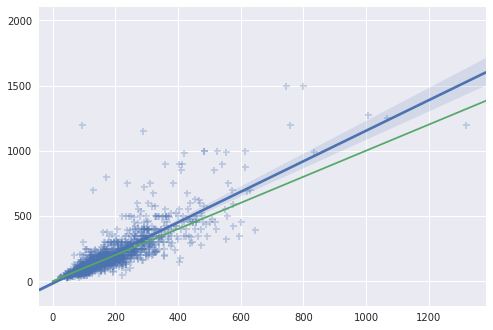

In [120]:
#sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,2000), range(0,2000))
# plt.xlim((0,3000))
# plt.ylim((0,3000));

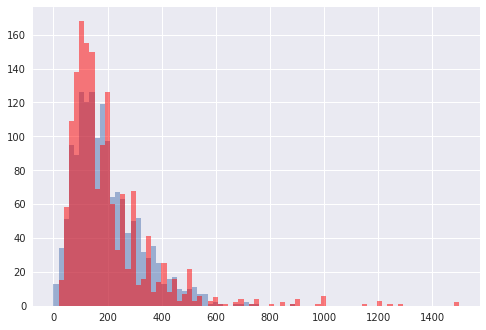

In [121]:
plt.hist(y_pred, bins=np.linspace(0,1500, num=80), alpha=0.5)
plt.hist(y_test, bins=np.linspace(0,1500, num=80), alpha=0.5, color='r');
# plt.hist(np.expm1(y_pred), bins=np.linspace(0,3000, num=80), alpha=0.5)
# plt.hist(np.expm1(y_test), bins=np.linspace(0,3000, num=80), alpha=0.5, color='r');

In [122]:
rfr = RandomForestRegressor(n_estimators=500, n_jobs=-1)#min_samples_split=2, min_samples_leaf=1)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)

rfr.score(X_test, y_test)

94.3651497569
51.1776364804
26.762


0.65409903877384667

In [123]:
rfrl = RandomForestRegressor(n_estimators=500, n_jobs=-1)#min_samples_split=2, min_samples_leaf=1)
rfrl.fit(Xl_train, yl_train)
yl_pred = rfrl.predict(Xl_test)

print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))
rfrl.score(Xl_test, yl_test)

92.5192304187
48.4258835607
25.5657514197


0.7723370903511142

In [124]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   16.249
Percent within 10 of price:  31.214
Percent within 20 of price:  54.849

Median error (percent):      17.638

Percent within 5 of price:   15.992
Percent within 10 of price:  32.241
Percent within 20 of price:  57.033

Median error (percent):      17.161


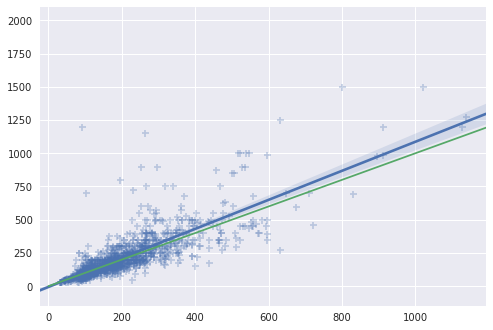

In [125]:
# sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,2000), range(0,2000))
# plt.xlim((0,3000))
# plt.ylim((0,3000));

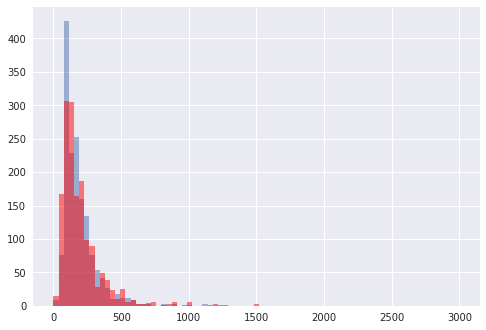

In [126]:
# plt.hist(y_pred, bins=np.linspace(0,1500, num=80), alpha=0.5)
# plt.hist(y_test, bins=np.linspace(0,1500, num=80), alpha=0.5, color='r');
plt.hist(np.expm1(yl_pred), bins=np.linspace(0,3000, num=80), alpha=0.5)
plt.hist(np.expm1(yl_test), bins=np.linspace(0,3000, num=80), alpha=0.5, color='r');

In [127]:
xgb = XGBRegressor(n_estimators=1000)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print rmse(y_pred, y_test),
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)
xgb.score(X_test, y_test)

91.8978329791 49.5787392832
26.7288970947


0.67195075469504695

In [128]:
xgbl = XGBRegressor(n_estimators=1000)
xgbl.fit(Xl_train, yl_train)
yl_pred = xgbl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_test), np.expm1(yl_pred))
xgbl.score(Xl_test, yl_test)

85.6787030229
44.9333260536
22.3376464844


0.79992851475577775

In [129]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   15.350
Percent within 10 of price:  29.544
Percent within 20 of price:  53.629

Median error (percent):      18.404

Percent within 5 of price:   17.405
Percent within 10 of price:  34.875
Percent within 20 of price:  58.767

Median error (percent):      15.641


In [130]:
etr = ExtraTreesRegressor(n_jobs=-1, n_estimators=400, bootstrap=True)
etr.fit(X_train, y_train)
y_pred = etr.predict(X_test)
print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)
etr.score(X_test, y_test)

91.0814409193
49.0491249197
25.6475


0.67775344208090604

In [131]:
etrl = ExtraTreesRegressor(n_jobs=-1, n_estimators=400, bootstrap=True)
etrl.fit(Xl_train, yl_train)
yl_pred = etrl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))
etrl.score(Xl_test, yl_test)


91.4931240552
46.955920377
23.8949673372


0.78427302505238083

In [132]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   18.369
Percent within 10 of price:  31.728
Percent within 20 of price:  56.583

Median error (percent):      17.032

Percent within 5 of price:   16.956
Percent within 10 of price:  33.526
Percent within 20 of price:  58.703

Median error (percent):      16.008


In [14]:
gbr = GradientBoostingRegressor(n_estimators=300)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)
gbr.score(X_test, y_test)

87.6469171947
48.3531293374
27.3744068158


0.70159795681287607

In [15]:
gbrl = GradientBoostingRegressor(n_estimators=300)
gbrl.fit(Xl_train, yl_train)
yl_pred = gbrl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))
gbrl.score(Xl_test, yl_test)

83.8113874687
43.937214657
22.429911406


0.80997260505926583

In [16]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   16.570
Percent within 10 of price:  30.379
Percent within 20 of price:  53.179

Median error (percent):      18.656

Percent within 5 of price:   18.304
Percent within 10 of price:  34.297
Percent within 20 of price:  58.638

Median error (percent):      15.857


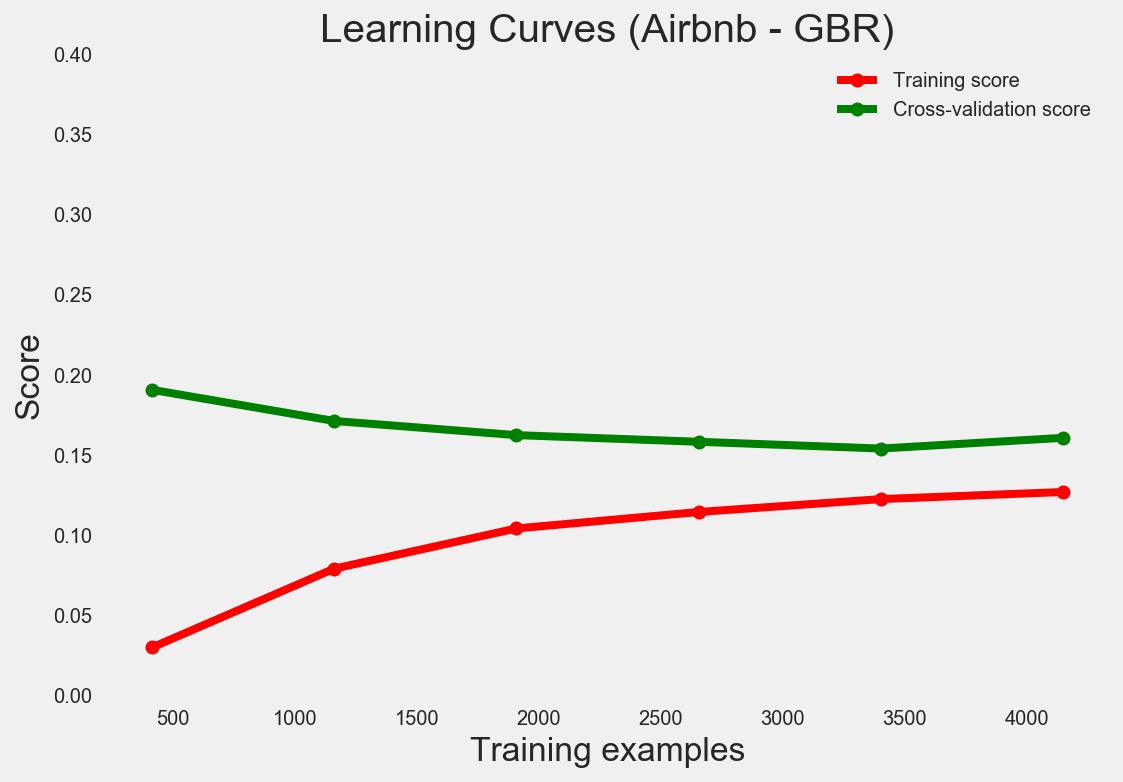

In [17]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 6)):
    plt.figure()
    plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
        scoring="neg_median_absolute_error")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, np.abs(train_scores_mean), 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, np.abs(test_scores_mean), 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
gbrl = GradientBoostingRegressor(n_estimators=400, max_depth=3, max_features='sqrt', 
                                 min_samples_leaf=3, min_samples_split=5)
title = "Learning Curves (Airbnb - GBR)"
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=100)
plot_learning_curve(gbrl, title, X, yl, (0.1, 1.01), cv=cv)
plt.ylim((0,0.4))
plt.savefig('bnb_best_gbr_median_ae_LC_vq.pdf')
plt.show()

## Property (tax roll) models (log_transform comparison)

In [21]:
# #res_rolls_cut = pd.read_pickle('./res_rolls_cut')
# res_rolls_cut = pd.read_pickle('./res_rolls_cut_geo')
# res_rolls_cut = res_rolls_cut[(res_rolls_cut.land_and_impro_val > 100000) & 
#                               (res_rolls_cut.land_and_impro_val < 5000000)]
# res_rolls_cut.shape

In [ ]:
# #res_rolls_cut = pd.read_pickle('./res_rolls_cut')
# res_rolls_test = pd.read_pickle('./res_rolls_cut_geo')
# res_rolls_test = res_rolls_test[(res_rolls_test.land_and_impro_val > 100000) & 
#                                 (res_rolls_test.land_and_impro_val < 7000000)]
# res_rolls_test.shape

In [8]:
#res_rolls_cut = pd.read_pickle('./res_rolls_cut')
res_rolls_cut = pd.read_pickle('./res_rolls_cut_geo')
res_rolls_test = pd.DataFrame(res_rolls_cut)
res_rolls_test = res_rolls_test[(res_rolls_test.land_and_impro_val > 100000) & 
                                (res_rolls_test.land_and_impro_val < 7000000)]
res_rolls_test.shape

(293177, 15)

(293177, 15)


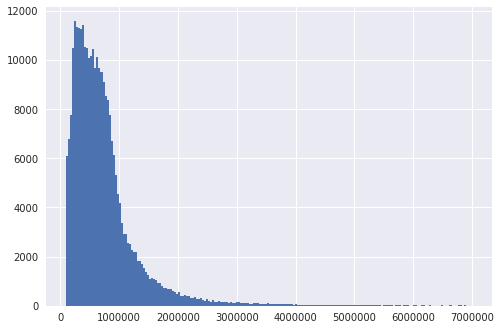

In [9]:
print res_rolls_test.shape
res_rolls_test.land_and_impro_val.hist(bins=200);

In [10]:
res_rolls_test = compile_model_data('crime and 311', res_rolls_test, short_311_cats, 
                                    short_crime_cats, crime_15up, rec_15up, 
                                    r_crime=0.003, r_311=0.003)
res_rolls_test.shape

(293177, 31)

In [11]:
res_rolls_test = find_neigh_cnt('park_reg_pts', park_reg_pts, res_rolls_test, r=0.004)


In [12]:
res_rolls_test = find_neigh_cnt('ldn_76', ldn_76, res_rolls_test, r=0.001)
res_rolls_test = find_neigh_cnt('ldn_74', ldn_74, res_rolls_test, r=0.001)
res_rolls_test = find_neigh_cnt('ldn_72', ldn_72, res_rolls_test, r=0.001)
res_rolls_test = find_neigh_cnt('ldn_70', ldn_70, res_rolls_test, r=0.001)
res_rolls_test = find_neigh_cnt('ldn_66', ldn_66, res_rolls_test, r=0.001)

In [157]:
res_rolls_test

,Number of Bathrooms,Number of Bedrooms,Number of Rooms,Number of Stories,Number of Units,Property Area in Square Feet,Percent of Ownership,land_and_impro_val,age,latitude,...,SFHA Requests_cnt,Street Defects_cnt,Sidewalk or Curb_cnt,Color Curb_cnt,park_reg_pts,ldn_76,ldn_74,ldn_72,ldn_70,ldn_66
0,2.0,2,5,1,0,1670,1.00000,1901208.0,12.0,37.786291,...,0,112,62,6,0,158,151,141,135,156
1,3.0,3,6,1,1,1450,1.00000,866405.0,110.0,37.764694,...,0,21,24,17,36,178,175,190,202,192
2,3.0,3,5,2,1,1037,1.00000,590004.0,35.0,37.781386,...,61,61,25,0,88,182,159,180,164,174
4,2.0,2,10,3,1,2920,1.00000,321306.0,113.0,37.770028,...,0,51,12,11,238,70,112,148,166,187
10,3.0,3,6,1,1,1705,1.00000,717439.0,92.0,37.776400,...,0,53,24,1,0,0,0,0,0,113
11,4.0,4,11,2,3,2771,1.00000,1120850.0,117.0,37.779537,...,181,35,38,7,81,151,156,192,201,224
15,3.0,3,5,2,1,1090,1.00000,224754.0,33.0,37.751406,...,181,35,6,1,0,0,0,11,19,258
16,10.0,10,22,2,1,3924,1.00000,2001739.0,44.0,37.761491,...,0,60,13,9,0,2,66,75,63,193
25,4.0,4,8,1,1,1445,1.00000,1280000.0,66.0,37.734753,...,0,48,28,4,9,115,136,137,140,246
30,2.0,2,5,1,1,1043,1.00000,173287.0,37.0,37.744909,...,0,63,42,15,74,95,114,101,110,109


In [13]:
# Predictors and target

drop_cols = ['latitude', 'longitude', 'land_and_impro_val', 'geometry', 'census_tract']
keep_cols = [x for x in res_rolls_test.columns.values if x not in drop_cols]
X = res_rolls_test[keep_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)

y = res_rolls_test.land_and_impro_val.values
yl = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, yl, test_size=0.25, random_state=100)


In [14]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)

linreg.score(X_test, y_test)

537235.035687
340945.729066
239160.631005


0.29731903309133934

In [15]:
linregl = LinearRegression()
linregl.fit(Xl_train, yl_train)
yl_pred = linregl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))

linregl.score(Xl_test, yl_test)

52079718250.9
272396092.221
218858.027578


0.25519217083916146

In [16]:
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

218858.027578
Percent within 5 of price:   6.681
Percent within 10 of price:  13.498
Percent within 20 of price:  26.973

Median error (percent):      37.964

Percent within 5 of price:   5.974
Percent within 10 of price:  12.159
Percent within 20 of price:  24.861

Median error (percent):      37.571


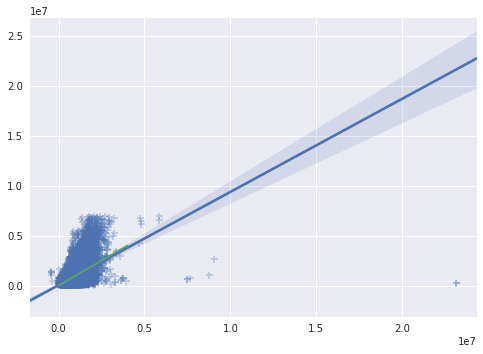

In [17]:
sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
# sns.regplot(np.expm1(y_pred), np.expm1(y_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,4000000), range(0,4000000))
# plt.xlim((0,3000))
# plt.ylim((0,3000));

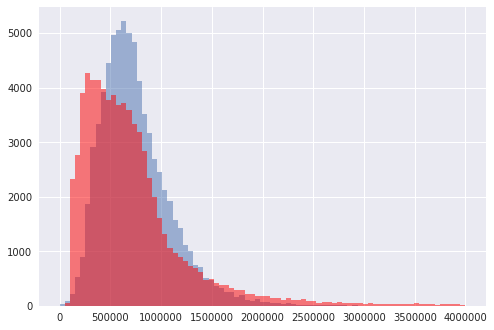

In [18]:
plt.hist(y_pred, bins=np.linspace(0,4000000, num=80), alpha=0.5)
plt.hist(y_test, bins=np.linspace(0,4000000, num=80), alpha=0.5, color='r');
# plt.hist(np.expm1(y_pred), bins=np.linspace(0,3000, num=80), alpha=0.5)
# plt.hist(np.expm1(y_test), bins=np.linspace(0,3000, num=80), alpha=0.5, color='r');

In [23]:
rfr = RandomForestRegressor(n_jobs= -1, n_estimators= 600, 
                            min_samples_split= 2, min_samples_leaf= 1)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)

rfr.score(X_test, y_test)

232611.56205
107251.340263
41000.0474939


0.86826774355500791

In [24]:
rfrl = RandomForestRegressor(n_jobs= -1, n_estimators= 600,
                            min_samples_split= 2, min_samples_leaf= 1)
rfrl.fit(Xl_train, yl_train)
yl_pred = rfrl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))

rfrl.score(Xl_test, yl_test)

248011.948711
109763.065013
37394.8638381


0.8567797355253568

In [25]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   40.430
Percent within 10 of price:  60.422
Percent within 20 of price:  77.214

Median error (percent):      6.787

Percent within 5 of price:   42.554
Percent within 10 of price:  62.318
Percent within 20 of price:  78.356

Median error (percent):      6.284


In [22]:
params = {'n_estimators': (500, 600, 700),
          'min_samples_split': (2, 3, 4, 5, 6),
          'min_samples_leaf': (1, 2, 3)}

rfrl = RandomForestRegressor(n_jobs=-1)
gs_rfrl = GridSearchCV(rfrl, params, verbose=6, pre_dispatch=2)
gs_rfrl.fit(Xl_train, yl_train)
gs_rfrl.best_params_

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] min_samples_split=2, n_estimators=500, min_samples_leaf=1 .......
[CV]  min_samples_split=2, n_estimators=500, min_samples_leaf=1, score=0.804524, total=  53.0s
[CV] min_samples_split=2, n_estimators=500, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.0s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=500, min_samples_leaf=1, score=0.812728, total=  53.0s
[CV] min_samples_split=2, n_estimators=500, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=500, min_samples_leaf=1, score=0.805396, total=  52.6s
[CV] min_samples_split=2, n_estimators=600, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=600, min_samples_leaf=1, score=0.804747, total= 1.0min
[CV] min_samples_split=2, n_estimators=600, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.8min remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=600, min_samples_leaf=1, score=0.812638, total= 1.0min
[CV] min_samples_split=2, n_estimators=600, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=600, min_samples_leaf=1, score=0.805687, total= 1.0min
[CV] min_samples_split=2, n_estimators=700, min_samples_leaf=1 .......
[CV]  min_samples_split=2, n_estimators=700, min_samples_leaf=1, score=0.804779, total= 1.2min
[CV] min_samples_split=2, n_estimators=700, min_samples_leaf=1 .......
[CV]  min_samples_split=2, n_estimators=700, min_samples_leaf=1, score=0.812707, total= 1.2min
[CV] min_samples_split=2, n_estimators=700, min_samples_leaf=1 .......
[CV]  min_samples_split=2, n_estimators=700, min_samples_leaf=1, score=0.805382, total= 1.2min
[CV] min_samples_split=3, n_estimators=500, min_samples_leaf=1 .......
[CV]  min_samples_split=3, n_estimators=500, min_samples_leaf=1, score=0.803880, total=  51.7s
[CV] min_samples_split=3, n_estimators=500, min_samples_leaf=1 .......
[CV]  min_samples_split=3, n_estimators=500, min_samples_leaf=1, score=0.811706, total=  51.6s
[CV] min_samples_split=3, n_estimators=500, min_samples_leaf=1 .......
[CV]

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 135.4min finished


{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}

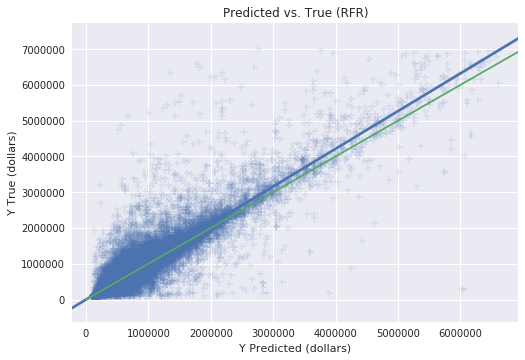

In [26]:
# sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.1})
plt.plot(range(0,7000000), range(0,7000000))
plt.xlabel('Y Predicted (dollars)')
plt.ylabel('Y True (dollars)')
plt.title('Predicted vs. True (RFR)')
plt.savefig('ass_pred_true_rfr_best_.pdf', facecolor='w')
plt.show();
# plt.xlim((0,3000))
# plt.ylim((0,3000));

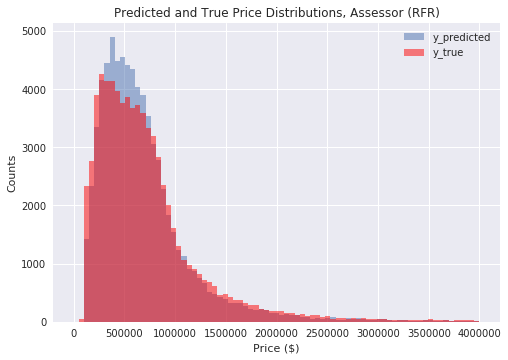

In [28]:
# plt.hist(y_pred, bins=np.linspace(0,1500, num=80), alpha=0.5)
# plt.hist(y_test, bins=np.linspace(0,1500, num=80), alpha=0.5, color='r');
plt.hist(np.expm1(yl_pred), bins=np.linspace(0,4000000, num=80), alpha=0.5, label='y_predicted')
plt.hist(np.expm1(yl_test), bins=np.linspace(0,4000000, num=80), alpha=0.5, color='r', label='y_true')
plt.title('Predicted and True Price Distributions, Assessor (RFR)')
plt.xlabel('Price ($)')
plt.ylabel('Counts')
plt.legend()
plt.savefig('ass_pred_true_dists_rfr_best_.pdf', facecolor='w')
plt.show();

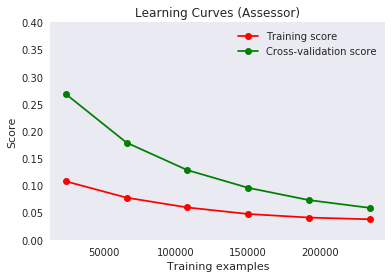

In [31]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 6)):
    plt.figure()
    plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
        scoring="neg_median_absolute_error")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, np.abs(train_scores_mean), 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, np.abs(test_scores_mean), 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

rfrl = RandomForestRegressor(n_estimators=600, n_jobs=-1, 
                             min_samples_split=2, min_samples_leaf=1)
title = "Learning Curves (Assessor)"
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=100)
plot_learning_curve(rfrl, title, X, yl, (0.1, 1.01), cv=cv)
plt.ylim((0,0.4))
plt.savefig('ass_best_rfr_median_ae_LC_v2.pdf')
plt.show()

In [170]:
xgb = XGBRegressor(n_estimators=1000)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)
xgb.score(X_test, y_test)

409848.942173
270716.716264
187330.1875


0.59104344612560067

In [171]:
xgbl = XGBRegressor(n_estimators=1000)
xgbl.fit(Xl_train, yl_train)
yl_pred = xgbl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))

xgbl.score(Xl_test, yl_test)

442484.380655
272823.188344
178308.8125


0.47461893101776864

In [172]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   8.836
Percent within 10 of price:  17.595
Percent within 20 of price:  35.264

Median error (percent):      29.291

Percent within 5 of price:   8.318
Percent within 10 of price:  16.616
Percent within 20 of price:  33.088

Median error (percent):      30.429


In [173]:
etr = ExtraTreesRegressor(n_jobs=-1, n_estimators=400, bootstrap=True)
etr.fit(X_train, y_train)
y_pred = etr.predict(X_test)
print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)

etr.score(X_test, y_test)

224064.886131
105480.11678
41153.9963373


0.87777018903305781

In [174]:
etrl = ExtraTreesRegressor(n_jobs=-1, n_estimators=400, bootstrap=True)
etrl.fit(Xl_train, yl_train)
yl_pred = etrl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))

etrl.score(Xl_test, yl_test)

242344.518852
108567.84
37731.8201929


0.86316643998114384

In [175]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   40.396
Percent within 10 of price:  60.258
Percent within 20 of price:  77.108

Median error (percent):      6.826

Percent within 5 of price:   42.378
Percent within 10 of price:  61.883
Percent within 20 of price:  78.349

Median error (percent):      6.350


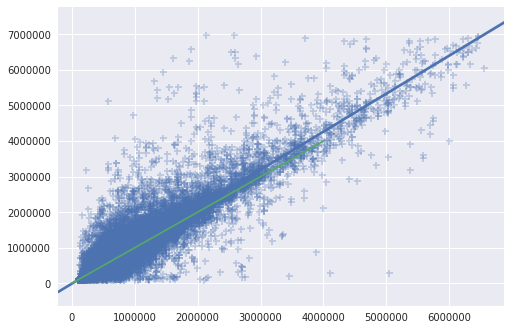

In [176]:
# sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,4000000), range(0,4000000))
# plt.xlim((0,3000))
# plt.ylim((0,3000));

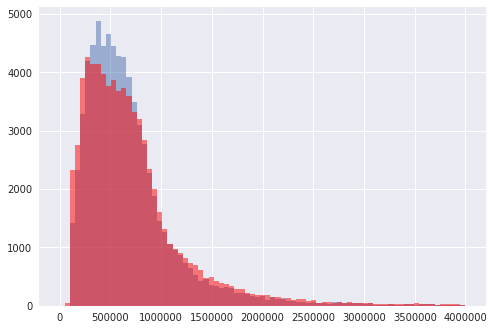

In [177]:
# plt.hist(y_pred, bins=np.linspace(0,1500, num=80), alpha=0.5)
# plt.hist(y_test, bins=np.linspace(0,1500, num=80), alpha=0.5, color='r');
plt.hist(np.expm1(yl_pred), bins=np.linspace(0,4000000, num=80), alpha=0.5)
plt.hist(np.expm1(yl_test), bins=np.linspace(0,4000000, num=80), alpha=0.5, color='r');

In [149]:
gbr = GradientBoostingRegressor(n_estimators=300)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)
gbr.score(X_test, y_test)

434303.988967
284374.652016
195601.07977


0.54078383008392328

In [150]:
gbrl = GradientBoostingRegressor(n_estimators=300)
gbrl.fit(Xl_train, yl_train)
yl_pred = gbrl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))
gbrl.score(Xl_test, yl_test)

463951.882699
285758.371865
186004.036806


0.43540424931856914

In [151]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   8.518
Percent within 10 of price:  16.843
Percent within 20 of price:  33.731

Median error (percent):      30.610

Percent within 5 of price:   7.625
Percent within 10 of price:  15.219
Percent within 20 of price:  30.950

Median error (percent):      32.018
